#İş Problemi

# ***Bu projede şirketi terk edecek müşterileri tahmin edebilecek bir makine öğrenmesi modeli geliştirilmesi istenmektedir. Modeli geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını gerçekleştirilecektir. 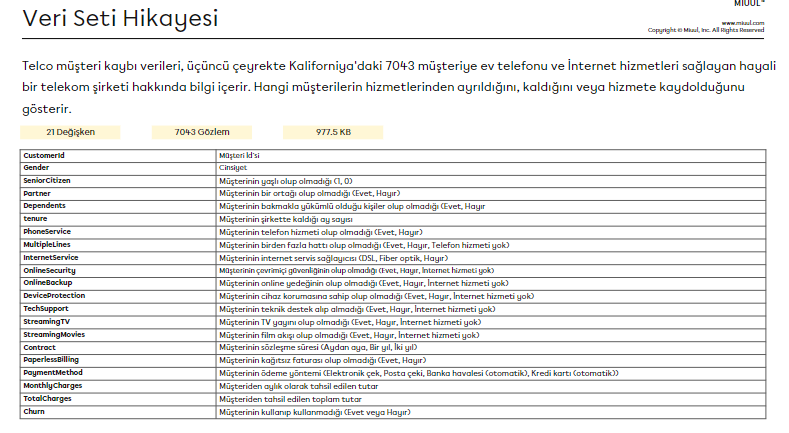***


#Gerekli Kütüphanelerin İmport Edilmesi ve Veri Setine Genel Bir Bakış

In [166]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt



import missingno as msno #eksik değer 
from datetime import date 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor #çok değişkenli aykırı değer yakalama yöntemi
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler #standartlaştırma fonksiyonları

pd.set_option("display.max_columns", None) #bütün sütunları göster
pd.set_option("display.max_rows", None) #bütün satırları göster
pd.set_option("display.float_format", lambda x: "%.3f" % x) #virgülden sonra 3 basamak göster 
pd.set_option("display.width", 500) #500 sütun göster

In [167]:
def load_dataset():
  data = pd.read_csv("/content/Telco-Customer-Churn.csv")

  return data

In [229]:
df = load_dataset()

In [169]:
def check_df(dataframe, observations=5):
  print("######### head #########", "\n")
  print(dataframe.head(observations))
  print("\n","######### tail #########", "\n")
  print(dataframe.tail(observations))
  print("\n","######### shape #########", "\n")
  print(dataframe.shape)
  print("\n","######### information #########", "\n")
  print(dataframe.info())
  print("\n","######### types #########", "\n")
  print(dataframe.dtypes)
  print("\n","######### NA #########", "\n")
  print(dataframe.isnull().sum())
  print("\n","######### describe #########", "\n")
  print(dataframe.describe().T)


In [170]:
check_df(df)

######### head ######### 

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges Churn
0  7590-VHVEG  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No          No              No  Month-to-month              Yes           Electronic check          29.850        29.85    No
1  5575-GNVDE    Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No          No              No        One year               No               Mailed check          56.950       1889.5    No
2  3668-QPYBK    Male              0      No         No       2          Yes                No      

## *Görüleceği üzere veri seti 7043 gözlemden ve 21 adet değişkenden oluşmaktadır. Hedef değişkenimiz "churn" değişkenidir ve müşterinin hizmet almaya devam edip etmediği bilgisini vermektedir. Proje, bağımlı değişken olan "churn" değişkeninin bağımsız değişkenlerle olan ilişkisini tespit etmek üzerine yürütülecektir. Başka bir deyişle müşterilerin kayıp olma durumlarının diğer değişkenler dolayımında analizi gerçekleştirilecektir.*

#PRE-PROCESSİNG

---



Numerik ve Kategorik değişkenlerin tespiti ve analizi

## "TotalCharges" değişkeni numerik bir değişken olmasına rağmen veri setinde kategorik tipte olması nedeniyle type değişikliği yapılması gerekmektedir.

In [230]:
df["TotalCharges"] = pd.to_numeric(df.TotalCharges, errors='coerce')

## *Hedef değişkenimiz olan "Churn" değişkeni string ifadelerden, yani "Yes" ve "No"lardan oluşmaktadır. Fakat hem hedef değişkenin analizini yaparken string ifadelerin analizinin mümkün olmayışı hem de modelin gereksinimleri nedeniyle "Churn" değişkenini "1" ve "0"lardan oluşan numerik değişkene çevirmemiz gerekmektedir. Daha sonra gerçekleştireceğimiz encode işlemleriyle diğer değişkenlerin de modele hazırlanması gerçekleştirilecektir.*

In [231]:
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

In [232]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  
  #kategorik ve kategorik fakat kardinal değişkenlerin yakalanması
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
  
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
  
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
  
  cat_cols = cat_cols + num_but_cat
  
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #numerik değişkenlerin yakalanması
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')

  return cat_cols, num_cols, cat_but_car




In [233]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [234]:
print(f"Kategorik Değişkenler: {cat_cols}\n\nNumerik Değişkenler: {num_cols}\n\nKategorik fakat Kardinal Değişkenler: {cat_but_car}")


Kategorik Değişkenler: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Churn']

Numerik Değişkenler: ['tenure', 'MonthlyCharges', 'TotalCharges']

Kategorik fakat Kardinal Değişkenler: ['customerID']


In [176]:
def cat_summary(dataframe, col_name, plot=False):
    print(f"\n##################### {col_name} #####################\n")
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()




##################### gender #####################

        gender  Ratio
Male      3555 50.476
Female    3488 49.524


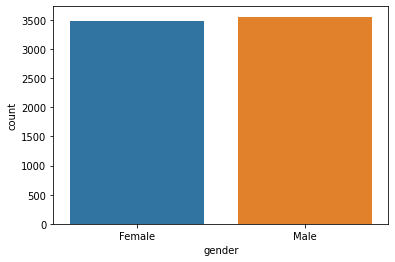


##################### Partner #####################

     Partner  Ratio
No      3641 51.697
Yes     3402 48.303


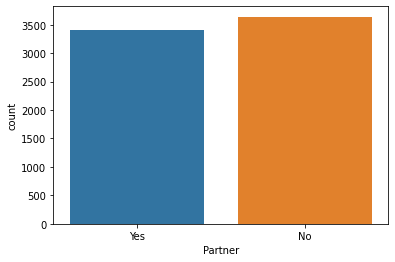


##################### Dependents #####################

     Dependents  Ratio
No         4933 70.041
Yes        2110 29.959


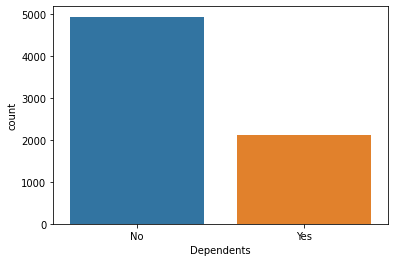


##################### PhoneService #####################

     PhoneService  Ratio
Yes          6361 90.317
No            682  9.683


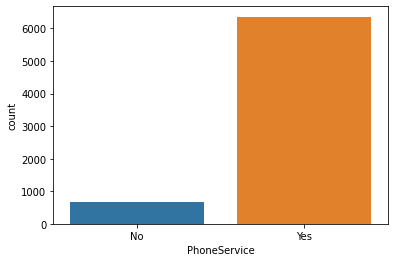


##################### MultipleLines #####################

                  MultipleLines  Ratio
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683


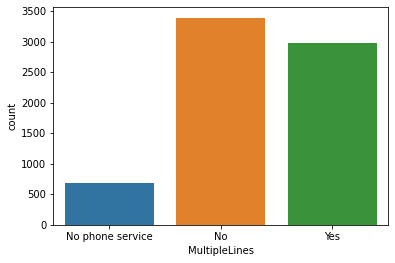


##################### InternetService #####################

             InternetService  Ratio
Fiber optic             3096 43.959
DSL                     2421 34.375
No                      1526 21.667


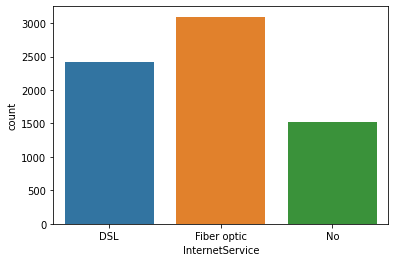


##################### OnlineSecurity #####################

                     OnlineSecurity  Ratio
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667


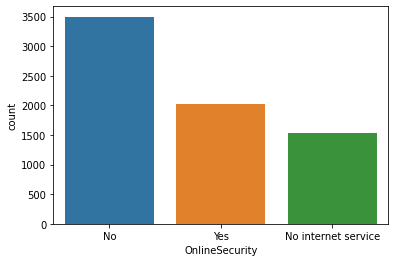


##################### OnlineBackup #####################

                     OnlineBackup  Ratio
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667


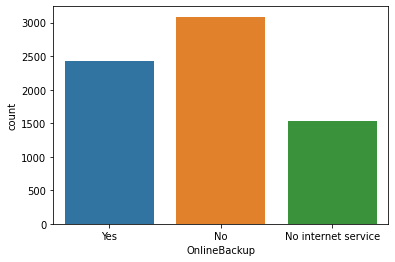


##################### DeviceProtection #####################

                     DeviceProtection  Ratio
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667


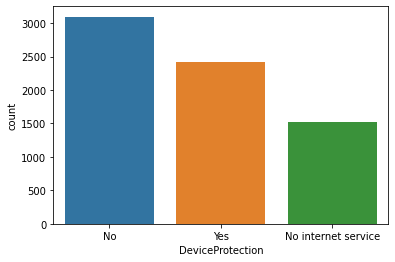


##################### TechSupport #####################

                     TechSupport  Ratio
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667


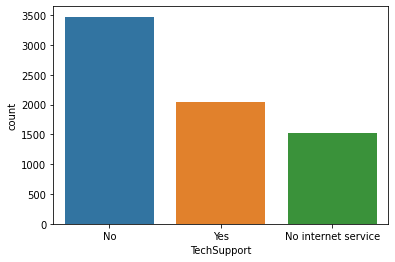


##################### StreamingTV #####################

                     StreamingTV  Ratio
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667


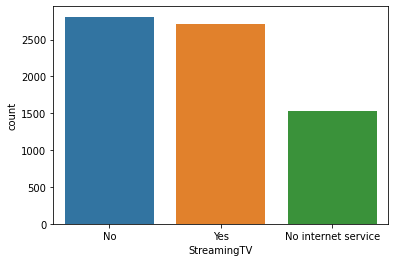


##################### StreamingMovies #####################

                     StreamingMovies  Ratio
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667


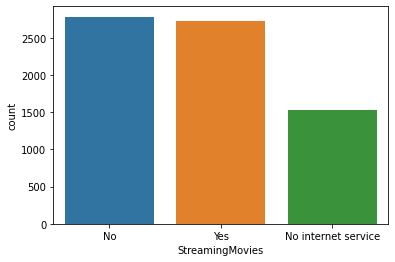


##################### Contract #####################

                Contract  Ratio
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914


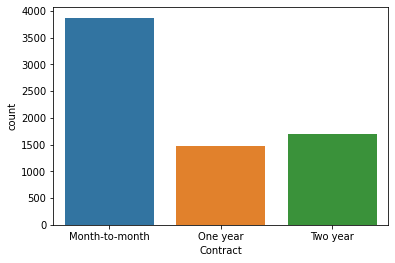


##################### PaperlessBilling #####################

     PaperlessBilling  Ratio
Yes              4171 59.222
No               2872 40.778


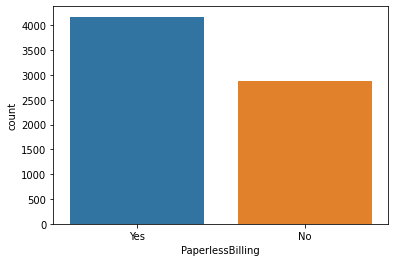


##################### PaymentMethod #####################

                           PaymentMethod  Ratio
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610


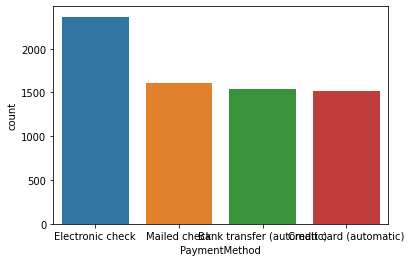


##################### SeniorCitizen #####################

   SeniorCitizen  Ratio
0           5901 83.785
1           1142 16.215


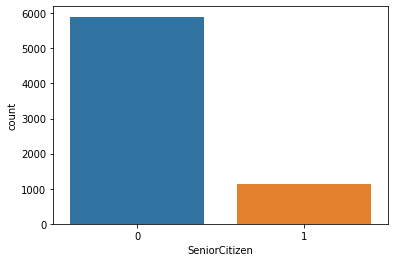


##################### Churn #####################

   Churn  Ratio
0   5174 73.463
1   1869 26.537


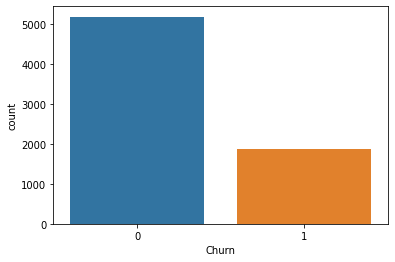

In [177]:
for col in cat_cols:
    cat_summary(df, col, True)

## ***Görüleceği üzere veri setinde 17 adet katgorik, 2 adet numerik değişken bulunmaktadır. Değişkenlerin frekansları kutu grafiklerinde görülmektedir.***
## ***Buna göre veri setinin müşterilerin cinsiyetleri, kullandıkları ve kullanmadıkları servisler, demografik, sosyal ve kişisel bazı özelliklerini içeren değişkenlerden oluştuğu söylenebilir.***

#Kategorik ve Numerik değişkenlere göre Hedef Değişkenin Analizi

In [178]:
print(f"Cat.Cols:{cat_cols},\nNum.Cols:{num_cols}")

Cat.Cols:['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Churn'],
Num.Cols:['tenure', 'MonthlyCharges', 'TotalCharges']


## *"Churn" değişkeni hedef değişken olduğundan kategorik değişkenler içerisinden çıkarma işlemini gerçekleştiriyoruz.*

In [235]:
cat_cols = [col for col in cat_cols if "Churn" not in col]

In [180]:
def target_summary_with_num(dataframe, target, numerical_cols):
  print(numerical_cols)
  print(dataframe.groupby(target).agg({numerical_cols: "mean"}))

In [181]:
for col in num_cols:
  target_summary_with_num(df, "Churn", col)

tenure
       tenure
Churn        
0      37.570
1      17.979
MonthlyCharges
       MonthlyCharges
Churn                
0              61.265
1              74.441
TotalCharges
       TotalCharges
Churn              
0          2555.344
1          1531.796


In [182]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")


In [183]:
for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

gender
        TARGET_MEAN  Count  Ratio
Female        0.269   3488 49.524
Male          0.262   3555 50.476


Partner
     TARGET_MEAN  Count  Ratio
No         0.330   3641 51.697
Yes        0.197   3402 48.303


Dependents
     TARGET_MEAN  Count  Ratio
No         0.313   4933 70.041
Yes        0.155   2110 29.959


PhoneService
     TARGET_MEAN  Count  Ratio
No         0.249    682  9.683
Yes        0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184


InternetService
             TARGET_MEAN  Count  Ratio
DSL                0.190   2421 34.375
Fiber optic        0.419   3096 43.959
No                 0.074   1526 21.667


OnlineSecurity
                     TARGET_MEAN  Count  Ratio
No                         0.418   3498 49.666
No internet service        0.074   1526 21.667
Yes                        0.146   2019 28.667


O

#Aykırı Gözlemlerin Analizi

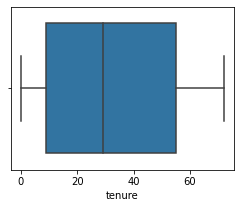

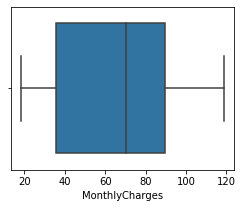

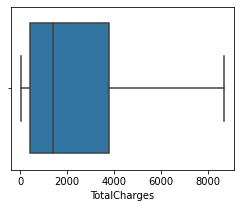

In [184]:
for col in num_cols:
    plt.subplots(figsize=(4, 3))
    sns.boxplot(x=df[col])
    plt.show(block=True)

## *İQR yöntemiyle eşik değerleri(up_limit ve low_limit) belirlediğimiz "outlier_thresholds" fonksiyonu:*

In [236]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [237]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [238]:
for col in num_cols:
  print(f"{col}: {check_outlier(df, col)}")

tenure: False
MonthlyCharges: False
TotalCharges: False


## *Hem boxplot yöntemiyle hem de yazdığımız fonksiyonlarla (outlier_thresholds, check_outlier) belirlediğimiz eşik değerlerinin üzerinde değerlerin olmadığı görülmektedir. Bu da veri setinde aykırı gözlemlerin bulunmadığı anlamına gelmektedir.*

> Girintili blok



#Eksik Gözlem Analizi

## Her bir değişkende kaç adet eksik gözlem olduğu sayılarına ulaştık. Yalnızca "TotalCharges" değişkeninde 11 adet eksik gözlem bulunduğu sonucuna ulaştık.

In [188]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

## ***Eksik değer sayısı 0'dan büyük olan değişkenleri belirlemek ve onların sayılarının dataframe'in toplam gözlem sayısına oranını göstermek için kullandığımız "missing_values_table" fonksiyonu:***

In [239]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [240]:
na_columns = missing_values_table(df, na_name=True)

              n_miss  ratio
TotalCharges      11  0.160


## Bu noktada "TotalCharges" değişkeninde bulunan eksik gözlemleri hangi değerlerle dolduracağımıza; doldurmayacaksak eksik gözlemleri veri setinden çıkarıp çıkarmayacağımıza karar vermemiz gerekmektedir. Veri setimiz 7043 gözlemden oluştuğundan 11 gözlemin veri setinden çıkarılması (drop) herhangi bir sorun yaratmayacaktır. Fakat yine de veri kaybı yaşamamak adına eksik değerleri "TotalCharges" değişkeninin medyanı ile doldurmak faydalı olabilir. Medyanı tercih etmemizin sebebi "TotalCharges" değişkeninin minimum ve maksimum değerleri arasında büyük fark bulunmasıdır. Aşağıda söz konusu değişkenin medyan ve ortalama değerleriyle özet istatistikleri gözlenebilir: 

In [191]:
df["TotalCharges"].median()

1397.475

In [192]:
df["TotalCharges"].mean()

2283.3004408418656

In [193]:
df["TotalCharges"].describe().T

count   7032.000
mean    2283.300
std     2266.771
min       18.800
25%      401.450
50%     1397.475
75%     3794.738
max     8684.800
Name: TotalCharges, dtype: float64

In [241]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

In [242]:
na_columns = missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


## ***Eksik değerleri gösteren fonksiyonumuzu yeniden çağırarak eksik gözlemlerden kurtulduğumuz bilgisine ulaşmış olduk.***

#Korelasyon Analizi

In [196]:
df[num_cols].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000,0.248,0.825
MonthlyCharges,0.248,1.000,0.651
TotalCharges,0.825,0.651,1.000


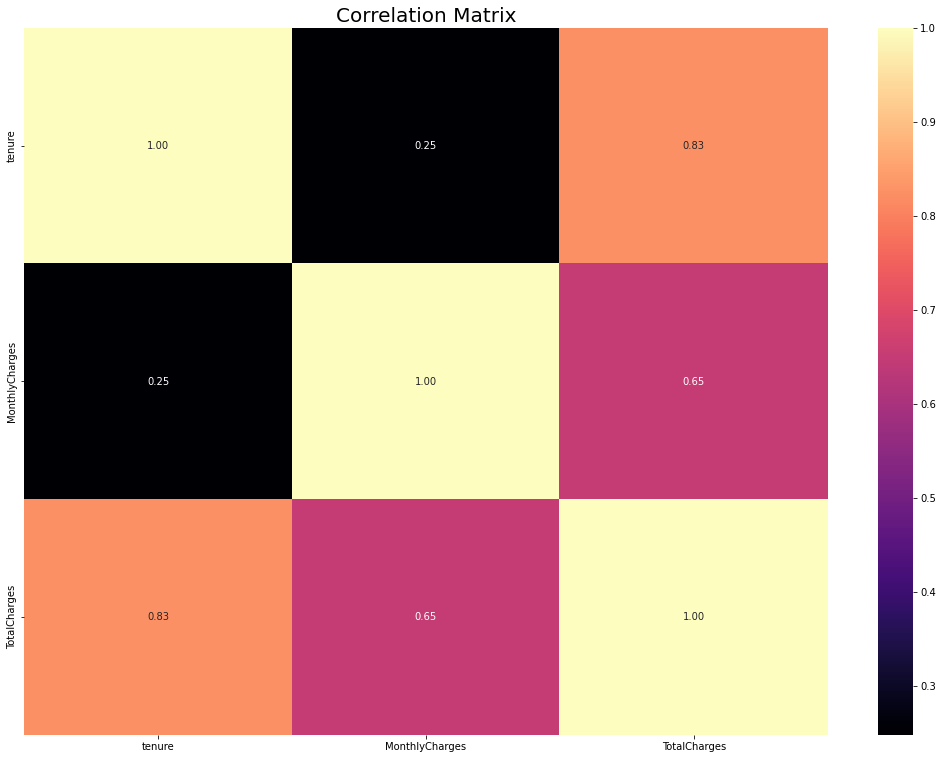

In [197]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show(block=True)

# ***Numerik değişkenlerin birbirleriyle olan korelasyonlarını ısı haritasıyla gözlemlediğimizde "TotalCharges" değişkeninin "tenure" ve "MonthlyCharges" değişkenleriyle pozitif yüksek korelasyona sahip olduğu söylenebilir.***

#Feature Extraction

Müşterilerin şirkette kaldıkları ay sayısını yıllara göre kategorilere ayırdığımız bir değişken:

In [243]:
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"CATEGORY_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"CATEGORY_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"CATEGORY_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"CATEGORY_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"CATEGORY_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"CATEGORY_TENURE_YEAR"] = "5-6 Year"

Müşterilerin herhangi bir destek ya da koruma hizmeti alıp almadıklarıyla ilgili bilgi veren yeni bir değişken:

In [244]:
df["PROTECTION_SUPPORT_STATUS"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

Müşterilerin otomatik ödeme yapıp yapmadıklarıyla ilgili bilgi veren yeni bir değişken:

In [245]:
df["AUTOPAYMENT_STATUS"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)


Müşterilerin yayın hizmeti alıp almadıklarıyla ilgili bilgi veren yeni bir değişken:

In [246]:
df["ANY_STREAMING_STATUS"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)


Müşterilerin aldıkları toplam servis sayılarıyla ilgili bilgi veren yeni bir değişken:

In [247]:
df['TOTALSERVİCES'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

Aylık sözleşmesi olan ve olmayan genç müşterilerle ilgili bilgi veren yeni bir değişken:

In [248]:
df["YOUNG_CONTRACT_MONTH"] = df.apply(lambda x: 1 if (x["Contract"] == "Month-to-month") and (x["SeniorCitizen"] == 0) else 0, axis=1)


Ortalama aylık ödemelerle ilgili bilgi veren yeni bir değişken:

In [249]:
df["AVG_TOTAL_CHARGES_MONTH"] = df["TotalCharges"] / (df["tenure"] + 1)


In [206]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,CATEGORY_TENURE_YEAR,PROTECTION_SUPPORT_STATUS,AUTOPAYMENT_STATUS,ANY_STREAMING_STATUS,TOTALSERVİCES,YOUNG_CONTRACT_MONTH,AVG_TOTAL_CHARGES_MONTH
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,1,0,0,1,1,14.925
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,1,0,0,3,0,53.986
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,1,0,0,3,1,36.050
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,40.016
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,1,0,0,1,1,50.550


In [ ]:
df.shape

(7043, 28)

## Yapmış olduğumuz değişken türetme işlemleriyle birlikte 21 olan değişken sayımızı 28'e çıkarmış olduk.

#Encoding İşlemleri

Encode etmeden önce kategorik ve numerik değişkenleri yeniden tespit etmek için "grab_col_names" fonksiyonunu çağırdık:

In [250]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 28
cat_cols: 23
num_cols: 4
cat_but_car: 1
num_but_cat: 7


In [251]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe




Sınıf sayısı 2 olan değişkenleri LabelEncoder ile encode işlemini gerçekleştiriyoruz.

In [252]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [253]:
for col in binary_cols:
    df = label_encoder(df, col)

In [211]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,CATEGORY_TENURE_YEAR,PROTECTION_SUPPORT_STATUS,AUTOPAYMENT_STATUS,ANY_STREAMING_STATUS,TOTALSERVİCES,YOUNG_CONTRACT_MONTH,AVG_TOTAL_CHARGES_MONTH
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.850,29.850,0,0-1 Year,1,0,0,1,1,14.925
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.950,1889.500,0,2-3 Year,1,0,0,3,0,53.986
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.850,108.150,1,0-1 Year,1,0,0,3,1,36.050
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,40.016
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.700,151.650,1,0-1 Year,1,0,0,1,1,50.550


Sınıf sayısı 2'den fazla ve 10'dan az olan değişkenlerin belirlenmesi ve OneHotEncoder işleminden geçirilmesi:

In [254]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'CATEGORY_TENURE_YEAR',
 'TOTALSERVİCES']

In [255]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [256]:
df = one_hot_encoder(df, ohe_cols, drop_first=True)


In [165]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,AVG_TOTAL_CHARGES_MONTH,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,CATEGORY_TENURE_YEAR_1-2 Year,CATEGORY_TENURE_YEAR_2-3 Year,CATEGORY_TENURE_YEAR_3-4 Year,CATEGORY_TENURE_YEAR_4-5 Year,CATEGORY_TENURE_YEAR_5-6 Year,SeniorCitizen_1,PROTECTION_SUPPORT_STATUS_1,AUTOPAYMENT_STATUS_1,ANY_STREAMING_STATUS_1,TOTALSERVİCES_1,TOTALSERVİCES_2,TOTALSERVİCES_3,TOTALSERVİCES_4,TOTALSERVİCES_5,TOTALSERVİCES_6,TOTALSERVİCES_7,YOUNG_CONTRACT_MONTH_1
0,7590-VHVEG,0,1,0,0.014,0,1,0.115,0.001,0,0.004,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
1,5575-GNVDE,1,0,0,0.472,1,0,0.385,0.216,0,0.032,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,3668-QPYBK,1,0,0,0.028,1,1,0.354,0.010,0,0.019,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
3,7795-CFOCW,1,0,0,0.625,0,0,0.239,0.210,0,0.022,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0
4,9237-HQITU,0,0,0,0.028,1,1,0.522,0.015,0,0.030,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1


#Standartlaştırma ve Model Kurma İşlemleri

In [265]:
scaler = MinMaxScaler()


In [266]:
df[num_cols] = scaler.fit_transform(df[num_cols])

In [267]:
y = df["Churn"]


In [268]:
X = df.drop(["Churn","customerID"], axis=1)

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20)


In [270]:
from sklearn.ensemble import RandomForestClassifier

In [271]:
rf_model = RandomForestClassifier().fit(X_train, y_train)

In [272]:
y_pred = rf_model.predict(X_test)

In [273]:
accuracy_score(y_pred, y_test)

0.8045433033601515

Modelimiz %80 accuracy oranına sahiptir.